# Object detection demo
This notebook tests some object detection algorithms on static images, such as Faster-CNN, YOLO, on the Oxford III Pet Dataset. First load modules.

In [195]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from PIL import Image


## Download Oxford III Pet Dataset
Download dataset into `test_datasets/' directory.

In [196]:
pet_dataset = torchvision.datasets.OxfordIIITPet(root="./test_datasets", 
                                                 target_types="segmentation",
                                                 download=True)

In [197]:
pet_dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./test_datasets

In [198]:
N = len(pet_dataset)

In [199]:
idx=np.random.randint(N)
idx

1556

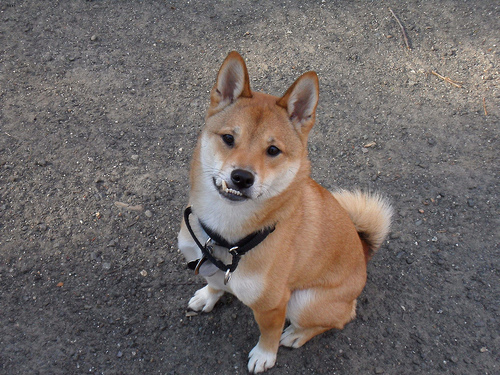

In [200]:
pet_dataset[idx][0]

# Build custom dataset and dataloader
Here create custom dataset to load files as required. Currently just testing the pre-trained networks, so we are not loading the bounding boxes (in annotations).

In [242]:
def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.images = [fname for fname in 
                       os.listdir(os.path.join(root, "images/")) 
                       if fname.endswith('.jpg')]
        self.annotations = [fname for fname in 
                            os.listdir(os.path.join(root, "annotations/trimaps/")) 
                            if fname.endswith('.png')]
        self.transform = transform
        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        fname = self.images[i]
        fpath = os.path.join(self.root, "images/", fname)
        img = self.transform(open_image(fpath))
        #TODO: load annotations 
        #fname = self.annotations[i]
        #fpath = os.path.join(self.root, "annotations/trimaps/", fname)
        #bbox = open_image(fpath)
        return img #, bbox


In [243]:
# Open data as tensor
pet_data = PetsDataset(root="./test_datasets/oxford-iiit-pet", 
                       transform = transforms.ToTensor())

In [244]:
pet_data[0].size()

torch.Size([3, 275, 183])

In [245]:
batch_size = 1       # Each image is different size, so have to run algorithm with batch size = 1.
pet_dataloader = DataLoader(pet_data, batch_size, shuffle=True)


In [246]:
example_image = next(iter(pet_dataloader))

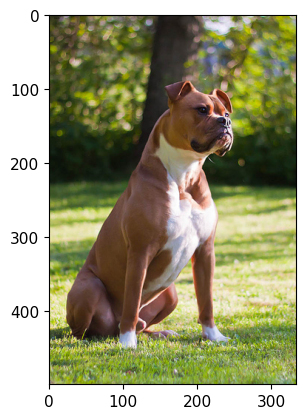

In [247]:
plt.imshow(  example_image[0].permute(1, 2, 0)  )
plt.show()

# Load pre-trained Faster-RCNN
Start by loading Faster Regional Convolutional Neural Network (Faster-RCNN) with fasterrcnn_resnet50_fpn. This is a two step detection algorithm so might not be the fastest. 

In [248]:
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)


In [249]:
fasterRCNN.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Run model on our example

In [250]:
%time example_output = fasterRCNN(example_image)

CPU times: user 1.28 s, sys: 1.45 s, total: 2.74 s
Wall time: 1.21 s


In [251]:
example_image, example_output

(tensor([[[[0.26275, 0.26275, 0.25098,  ..., 0.88235, 0.89412, 0.91765],
           [0.23922, 0.24706, 0.22353,  ..., 0.83137, 0.86667, 0.85098],
           [0.21176, 0.22745, 0.20784,  ..., 0.74118, 0.80392, 0.79216],
           ...,
           [0.52549, 0.56471, 0.58824,  ..., 0.52941, 0.44314, 0.42745],
           [0.47059, 0.47451, 0.50980,  ..., 0.51373, 0.46275, 0.49412],
           [0.41961, 0.50588, 0.60000,  ..., 0.48235, 0.46275, 0.47451]],
 
          [[0.30196, 0.29804, 0.27843,  ..., 0.87451, 0.87451, 0.92157],
           [0.26667, 0.27451, 0.24706,  ..., 0.88627, 0.88627, 0.88235],
           [0.22353, 0.24314, 0.22353,  ..., 0.80784, 0.85882, 0.88235],
           ...,
           [0.56863, 0.54902, 0.50980,  ..., 0.67059, 0.59608, 0.57647],
           [0.50980, 0.46275, 0.43529,  ..., 0.64314, 0.60000, 0.63137],
           [0.37647, 0.47843, 0.58824,  ..., 0.60784, 0.58431, 0.58431]],
 
          [[0.01569, 0.04314, 0.06667,  ..., 0.88627, 0.89804, 0.93725],
           [0

## Plot output

In [252]:
def plot_image_with_boxes(my_img, my_boxes):
    """my_img is torch tensor floats
    """
    plt.clf()
    my_img_RGB = my_img.mul(255).add_(0.5).clamp_(0, 255).type(torch.uint8)
    image_with_box = draw_bounding_boxes(my_img_RGB, my_boxes,
                                        width=4)
    plt.imshow(transforms.ToPILImage()(image_with_box))
    plt.show()

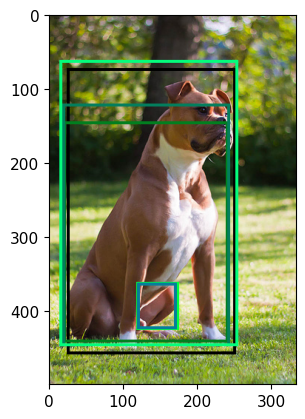

In [253]:
plot_image_with_boxes(example_image[0], example_output[0]['boxes'].detach())

In [254]:
print([weights.meta["categories"][label] for label in example_output[0]['labels']])

['dog', 'horse', 'person', 'cow', 'person', 'baseball glove']


In [255]:
print(example_output[0]['scores'])

tensor([0.96401, 0.46810, 0.10488, 0.08531, 0.06226, 0.05416], grad_fn=<IndexBackward0>)


## Load YOLO model for comparison

In [256]:
import torch

# Model
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /Users/lauraman/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-21 Python-3.11.3 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [257]:
# yolo takes PIL as input
example_pil = transforms.ToPILImage()(example_image[0])

In [258]:
%time yolo_output = yolo(example_pil)

CPU times: user 214 ms, sys: 61.8 ms, total: 276 ms
Wall time: 90.7 ms


In [259]:
yolo_output.print()

image 1/1: 500x334 1 dog
Speed: 14.7ms pre-process, 74.8ms inference, 0.5ms NMS per image at shape (1, 3, 640, 448)


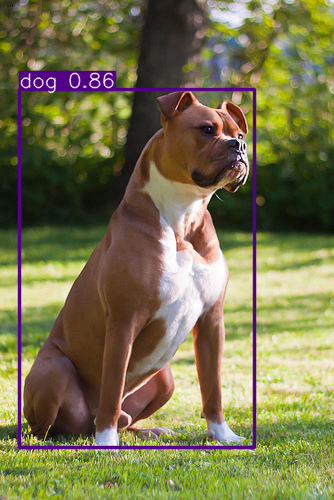

In [260]:
yolo_output.show()

In [261]:
yolo_output.pandas().xyxy

[        xmin       ymin        xmax        ymax  confidence  class name
 0  19.606762  89.854347  254.398117  447.681152    0.863909     16  dog]